<a href="https://colab.research.google.com/github/fjpAntunes/mean-field-tools/blob/main/experiments/anaylitcForwardNumericalBackwardExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Toy problem Setup:

* Forward component:
  $$ dX_t = -kX_t dt + dW_t $$

* Backwards component:
$$ Y_t = Y_T -\int_t^T 2X_s ds - \int_t^T Z_s dW_s, \\
Y_T = X_T^2 $$

### Analytic Solution
$$
Y_t = X_t^2 e^{-2k(T-t)} + \left( \frac{1 - e^{-2k(T-t)}}{2k} \right) + 2 X_t \left( \frac{1 - e^{-k(T-t)}}{k} \right)
$$

In [1]:
# @title Setup
!git clone -b develop https://github.com/fjpAntunes/mean-field-tools.git

Cloning into 'mean-field-tools'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 437 (delta 43), reused 43 (delta 31), pack-reused 324
Receiving objects: 100% (437/437), 5.22 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [2]:
%cd mean-field-tools/

/content/mean-field-tools


# Terminal Quadratic - With Drift

In [3]:
"""Tests Ornstein-Uhlenbeck as forward process"""

from mean_field_tools.deep_bsde.forward_backward_sde import (
    Filtration,
    BackwardSDE,
    ForwardSDE,
    ForwardBackwardSDE,
)
from mean_field_tools.deep_bsde.function_approximator import FunctionApproximatorArtist
import torch
import numpy as np


torch.cuda.empty_cache()

TIME_DOMAIN = torch.linspace(0, 1, 101)
NUMBER_OF_PATHS = 100_000
SPATIAL_DIMENSIONS = 1

K = 1

def OU_FUNCTIONAL_FORM(filtration):
    dummy_time = filtration.time_process[:, 1:, 0].unsqueeze(-1)
    integrand = torch.exp(K * dummy_time) * filtration.brownian_increments

    initial = torch.zeros(
        size=(filtration.number_of_paths, 1, filtration.spatial_dimensions)
    )
    integral = torch.cat([initial, torch.cumsum(integrand, dim=1)], dim=1)

    time = filtration.time_process[:, :, 0].unsqueeze(-1)
    path = torch.exp(-K * time) * integral
    return path


def BACKWARD_DRIFT(filtration: Filtration):
    X_t = filtration.forward_process

    return 2 * X_t

def ZERO_DRIFT(filtration: Filtration):
    t = filtration.time_process

    return 0*t

def TERMINAL_CONDITION(filtration: Filtration):
    X_T = filtration.forward_process[:, -1, :]

    return X_T**2

FILTRATION = Filtration(
    spatial_dimensions=SPATIAL_DIMENSIONS, time_domain=TIME_DOMAIN, number_of_paths=NUMBER_OF_PATHS, seed=0
)

forward_sde = ForwardSDE(
    filtration=FILTRATION,
    functional_form=OU_FUNCTIONAL_FORM,
)


device = "cuda" if torch.cuda.is_available() else "cpu"

backward_sde = BackwardSDE(
    terminal_condition_function=TERMINAL_CONDITION,
    filtration=FILTRATION,
    exogenous_process=["time_process", "forward_process"],
    drift=BACKWARD_DRIFT,
)
backward_sde.initialize_approximator(nn_args = {'device': device})


forward_backward_sde = ForwardBackwardSDE(
    filtration=FILTRATION, forward_sde=forward_sde, backward_sde=backward_sde
)



In [4]:
def ANALYTICAL_SOLUTION(x,t,T):
  return x**2 * np.exp(-2*K * (T - t)) + ( (1 - np.exp(- 2 * K * ( T - t ) ) ) / ( 2 * K )  ) + 2 * x * ( (1 - np.exp(- K * (T - t) ) ) / K )

artist = FunctionApproximatorArtist(
    save_figures=False,  analytical_solution=ANALYTICAL_SOLUTION
)


In [5]:
%pdb

Automatic pdb calling has been turned ON


Epoch 1


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


Epoch 2


100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


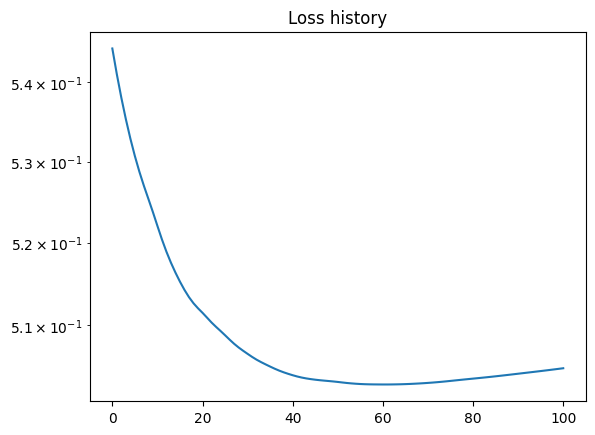

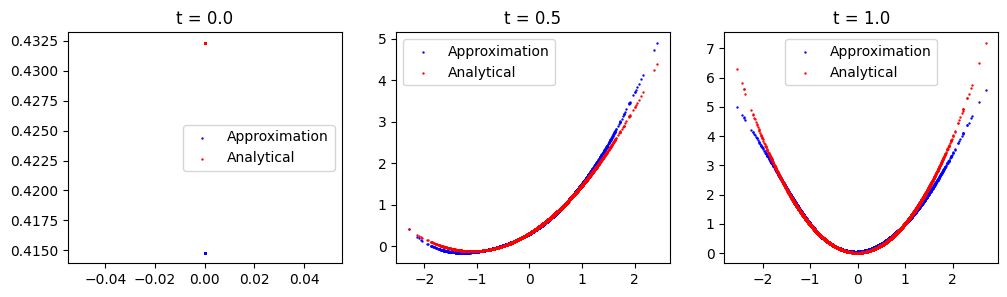

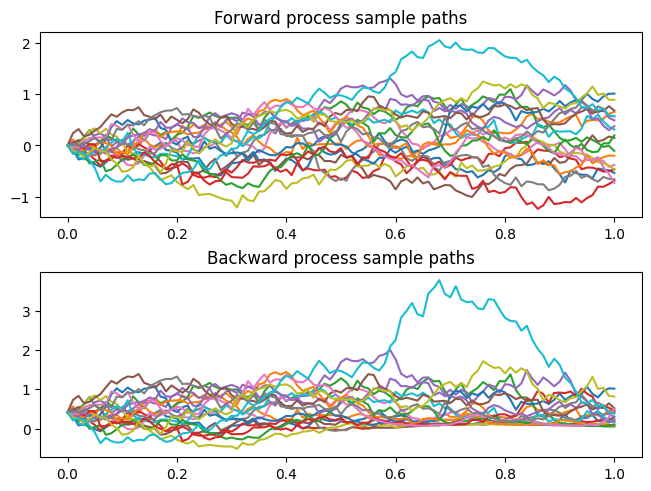

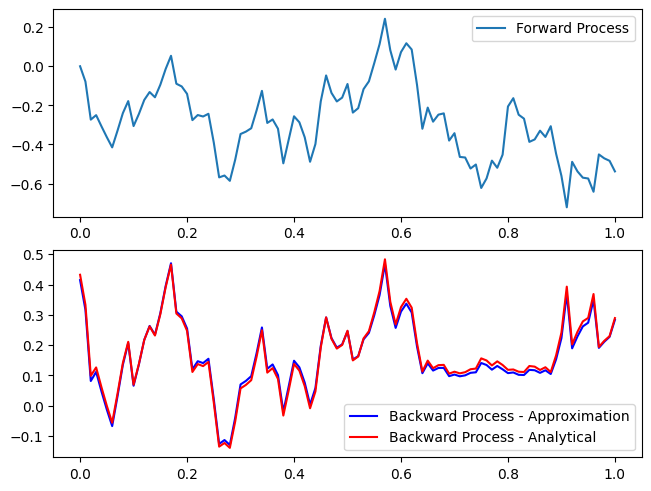

Epoch 3


100%|██████████| 100/100 [00:12<00:00,  7.97it/s]


Epoch 4


100%|██████████| 100/100 [00:12<00:00,  7.91it/s]


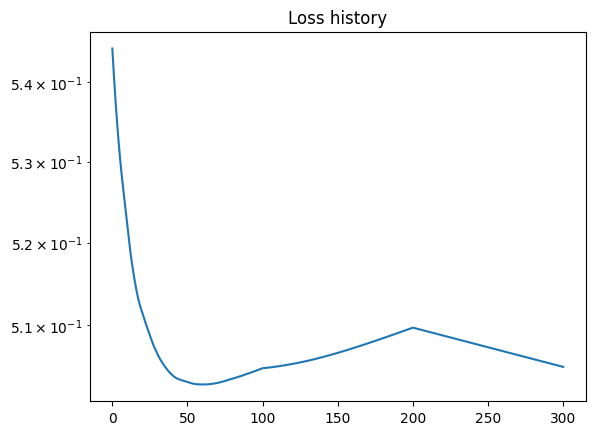

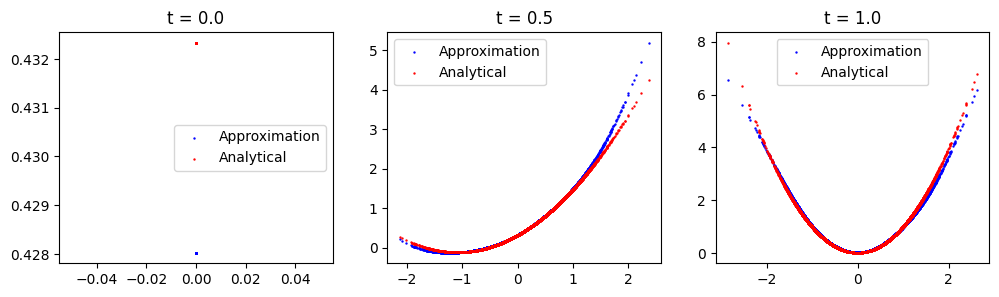

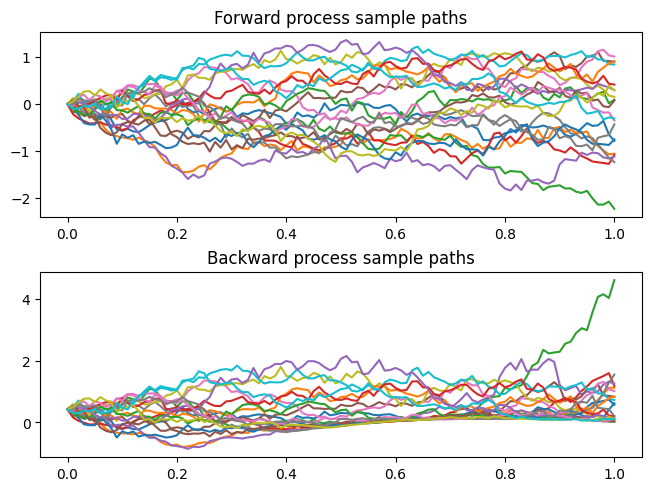

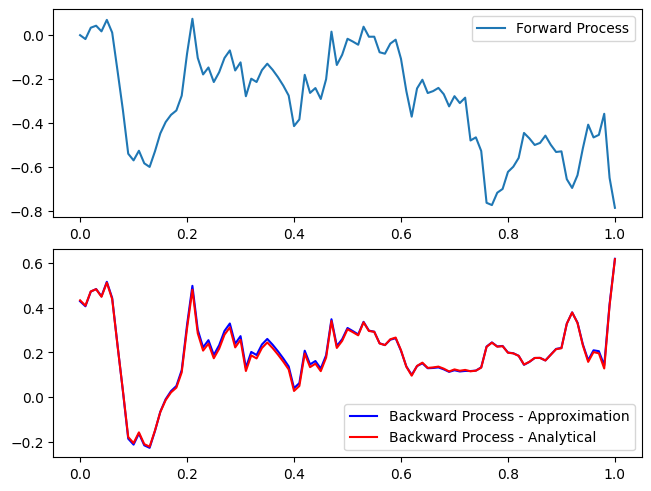

Epoch 5


100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


Epoch 6


100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


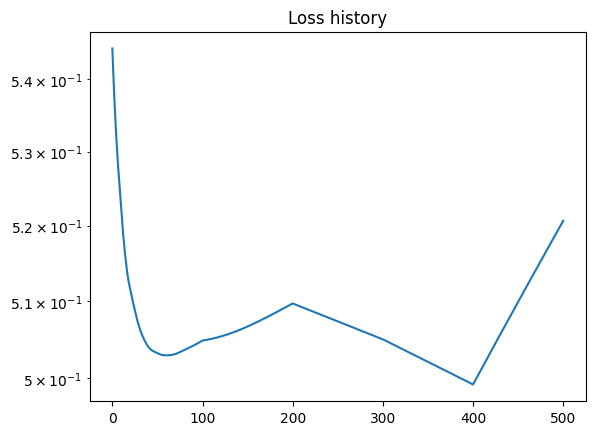

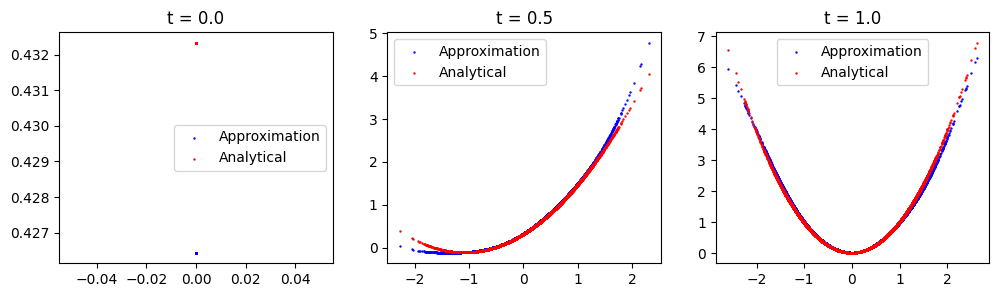

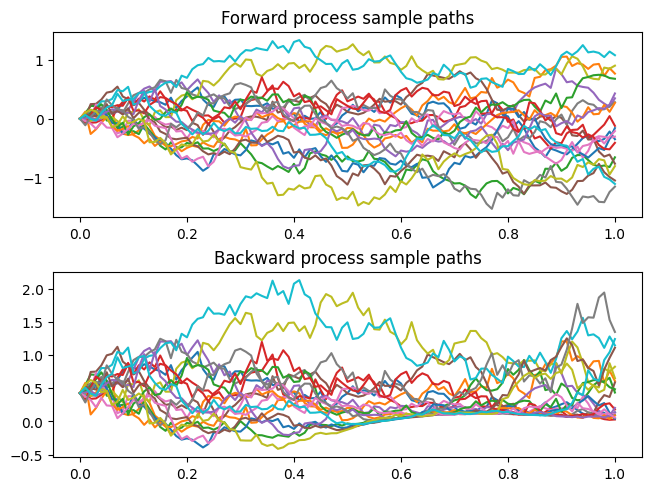

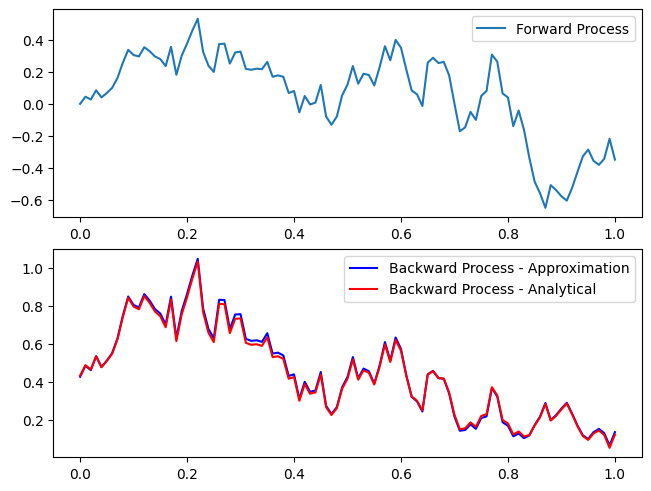

Epoch 7


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 8


100%|██████████| 100/100 [00:12<00:00,  7.86it/s]


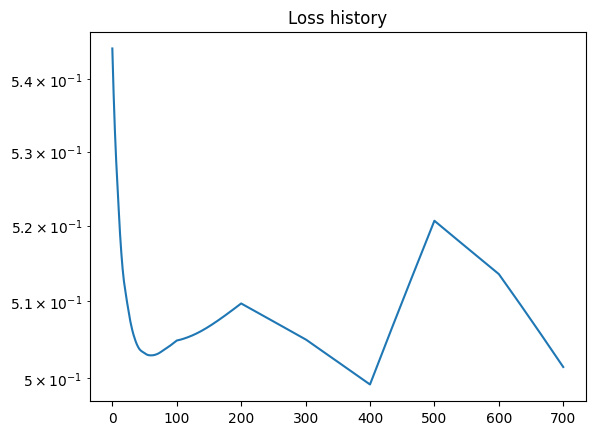

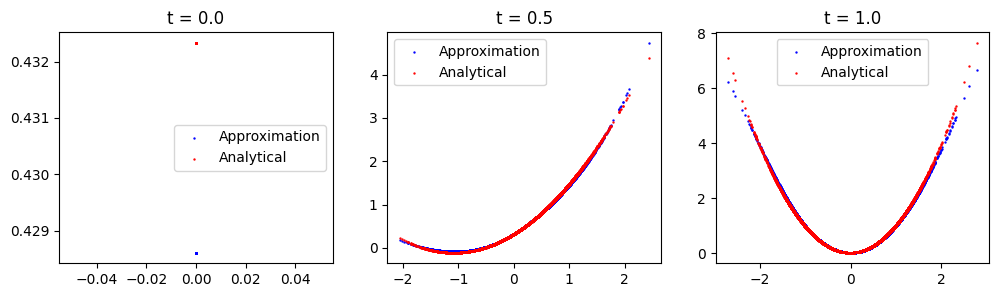

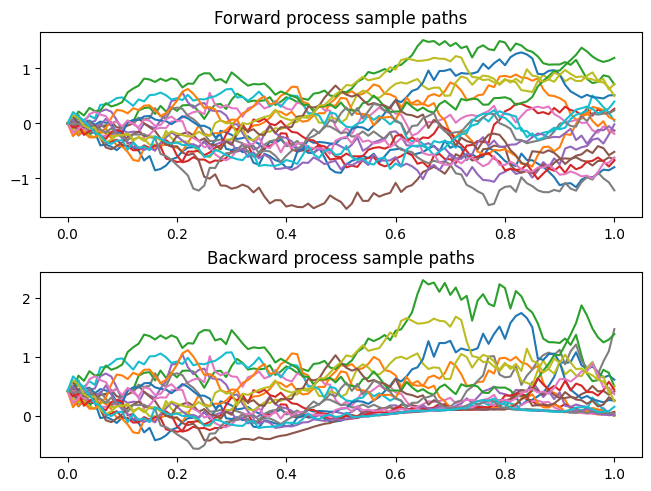

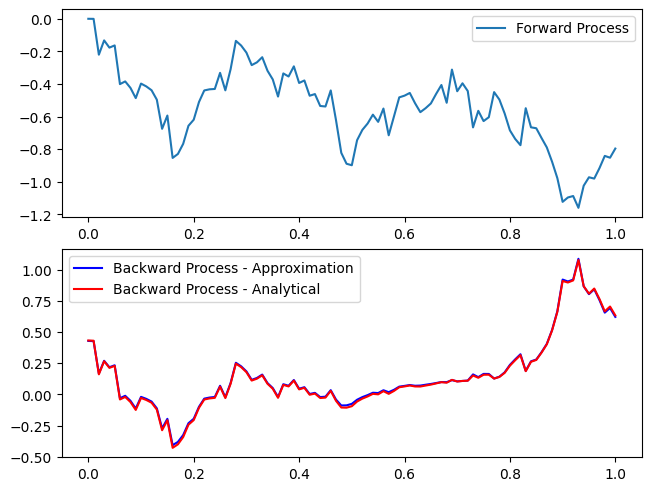

Epoch 9


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


Epoch 10


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


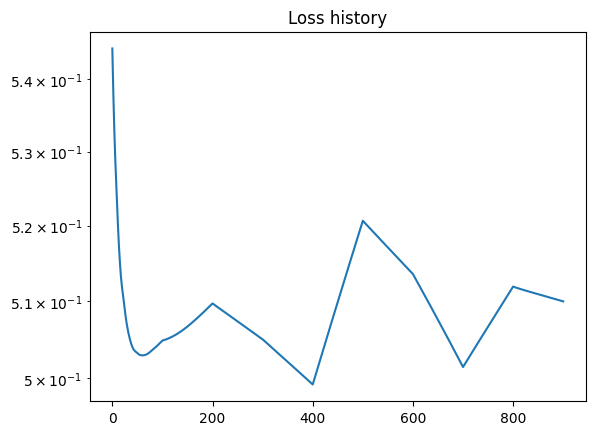

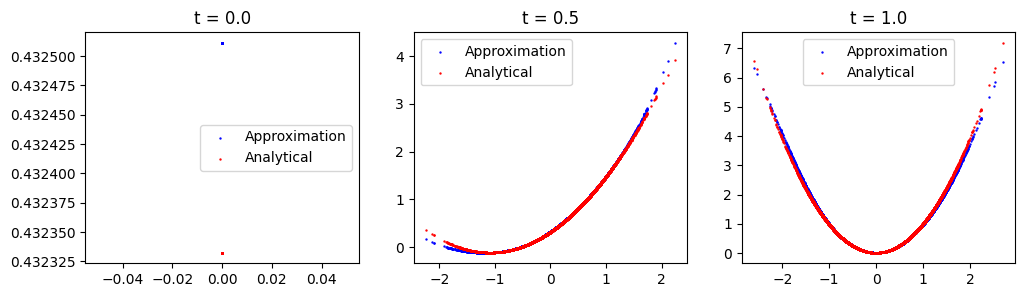

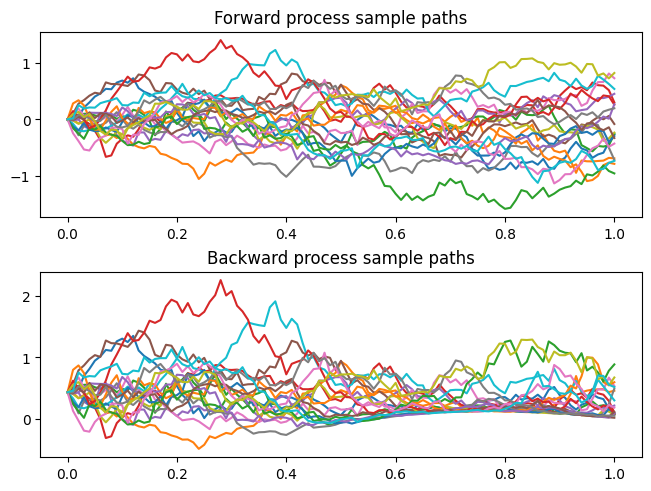

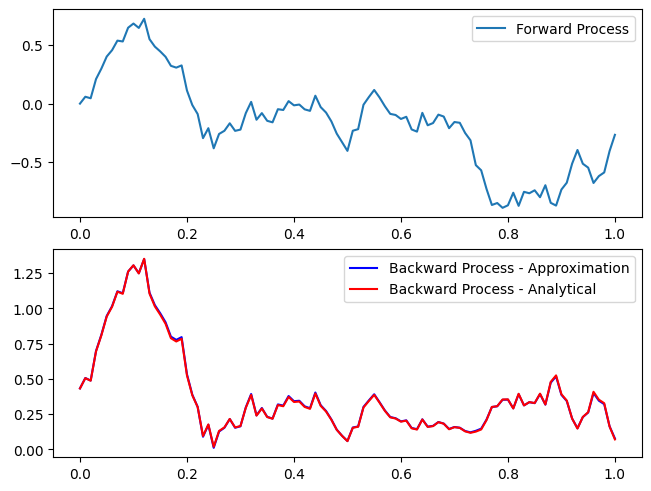

Epoch 11


100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


Epoch 12


100%|██████████| 100/100 [00:12<00:00,  7.75it/s]


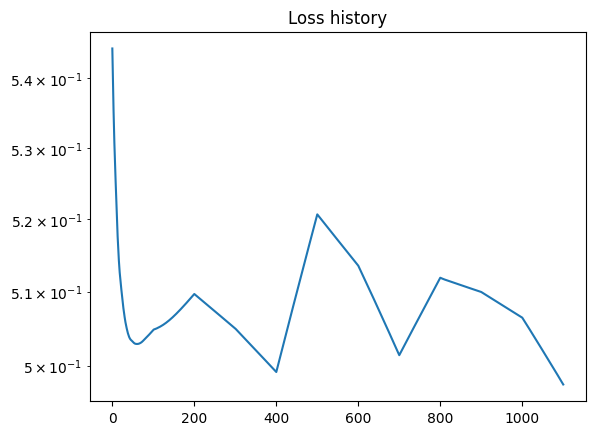

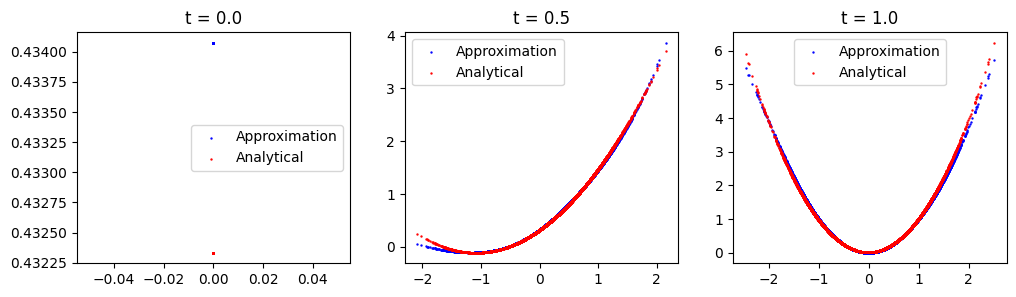

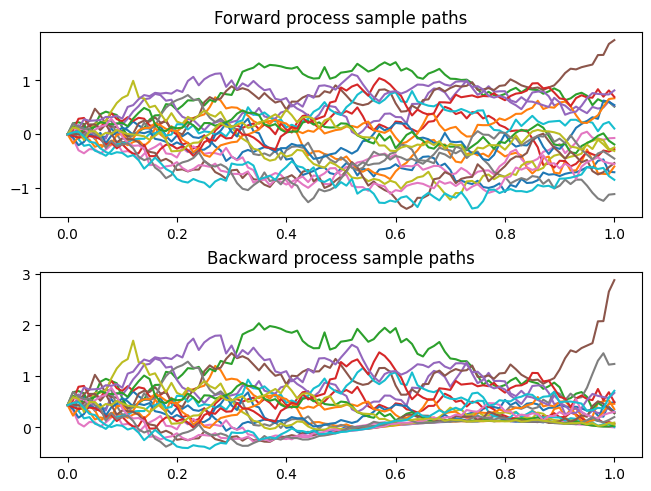

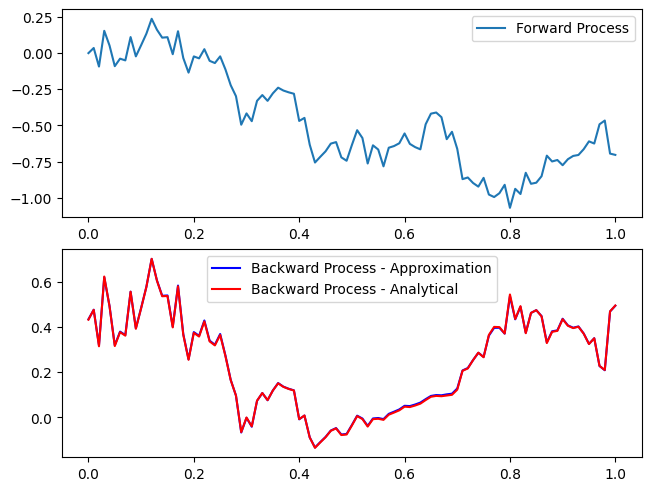

Epoch 13


100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


Epoch 14


100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


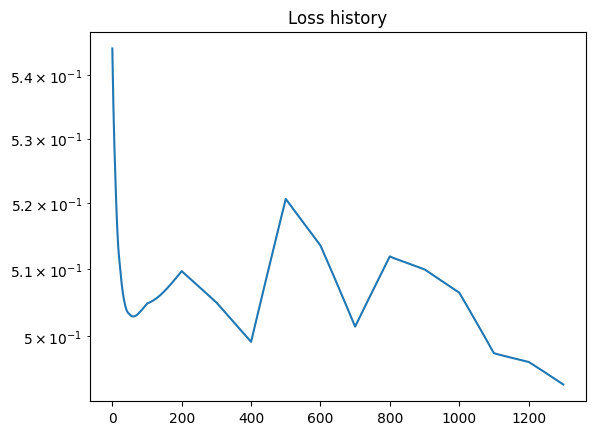

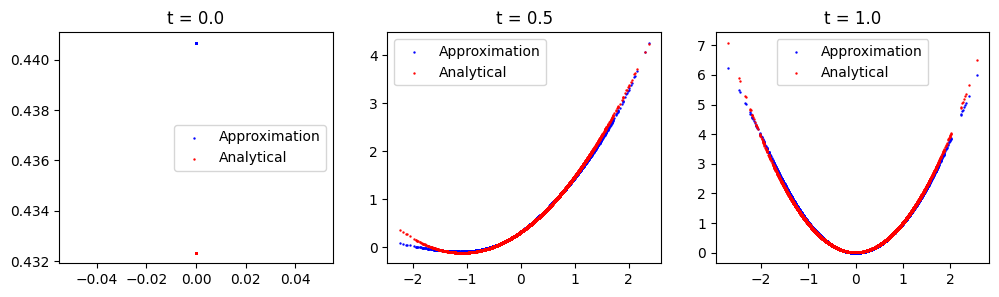

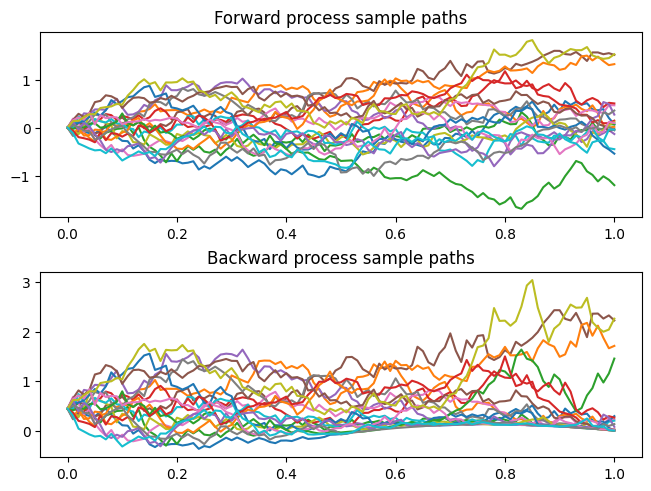

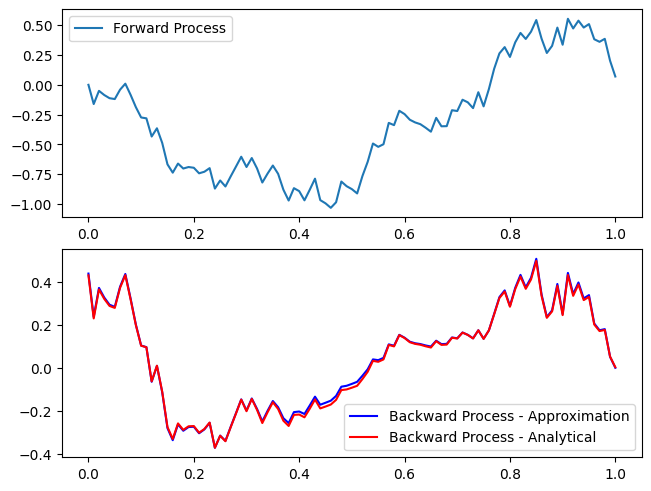

Epoch 15


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


Epoch 16


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


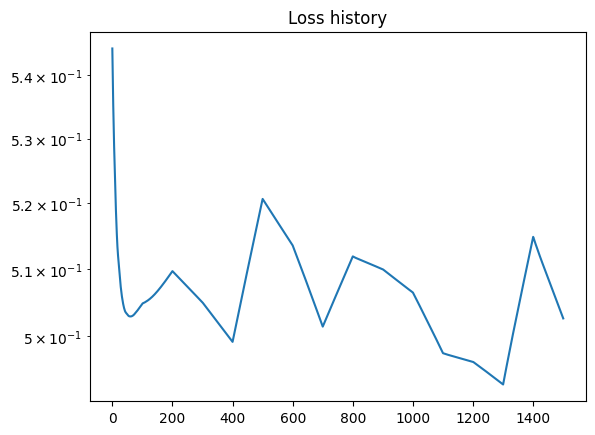

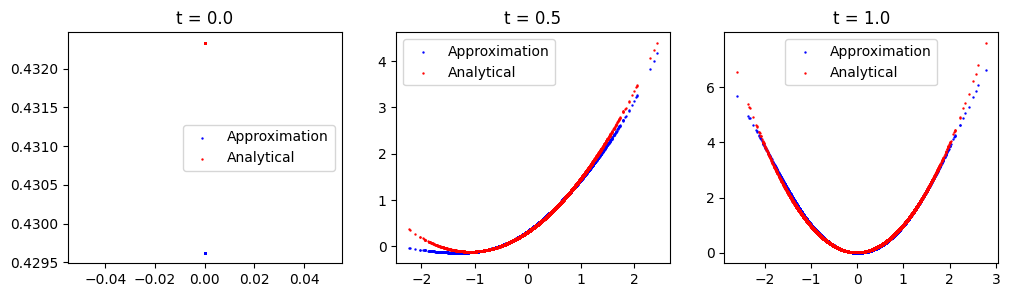

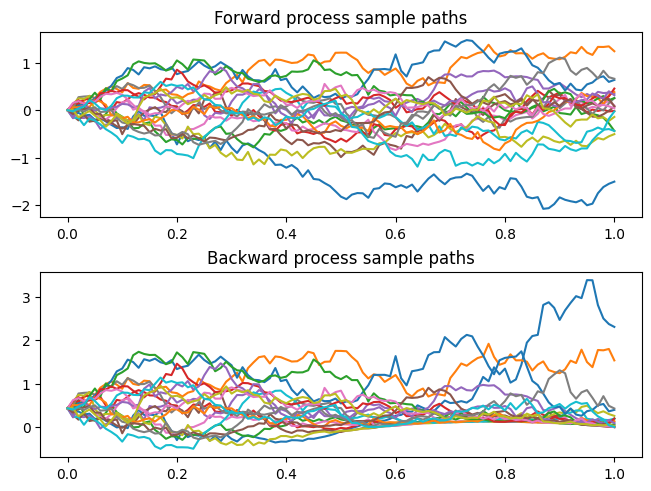

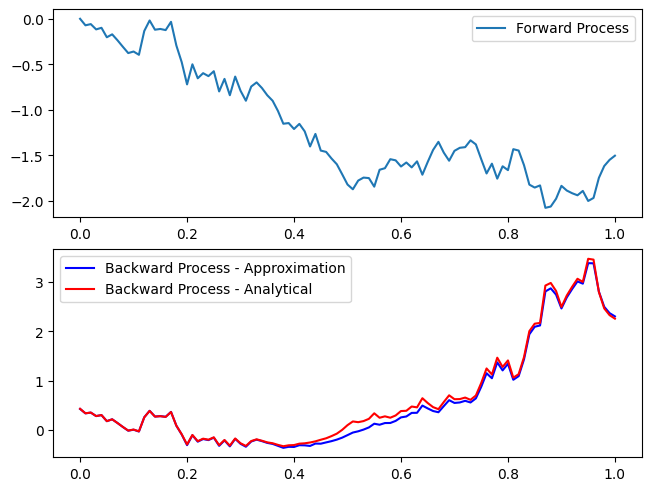

Epoch 17


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


Epoch 18


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


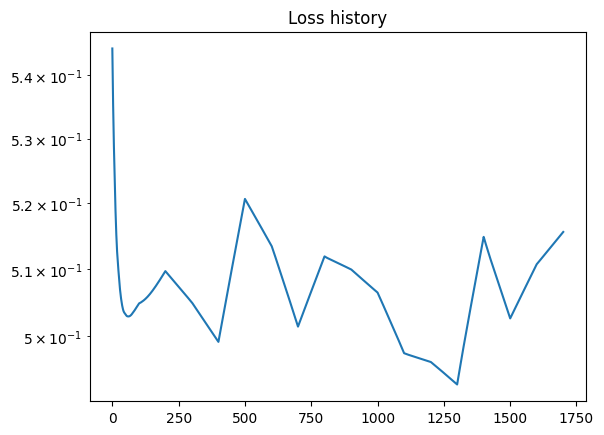

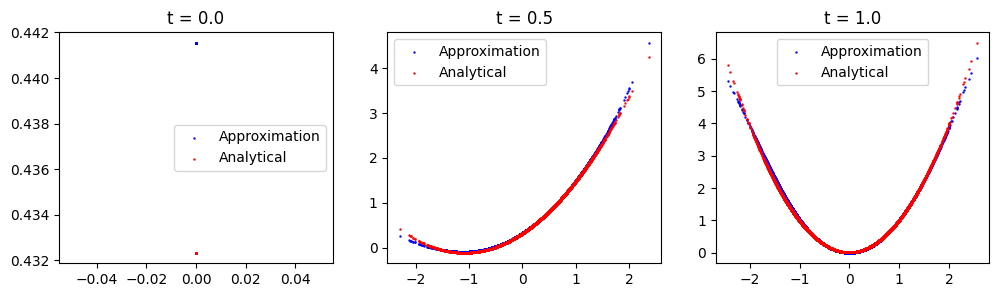

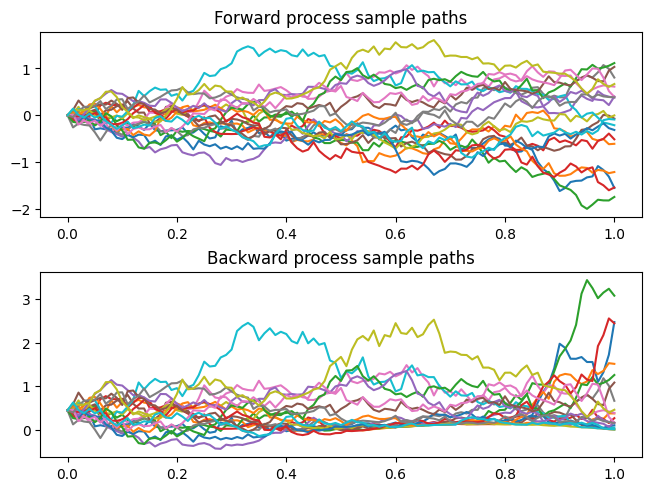

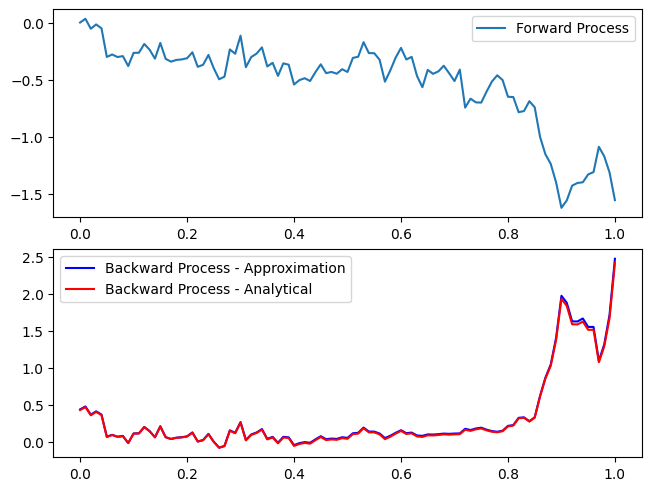

Epoch 19


100%|██████████| 100/100 [00:12<00:00,  7.84it/s]


Epoch 20


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


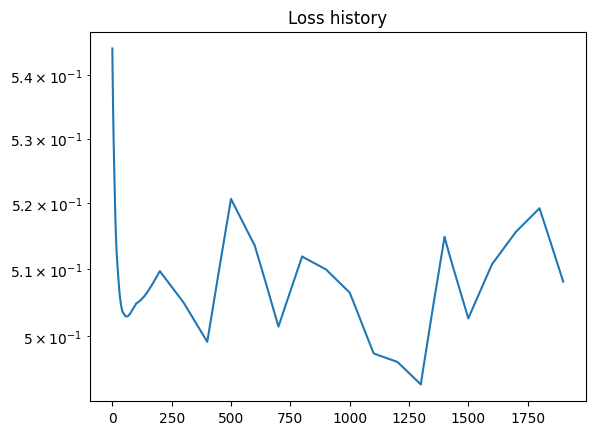

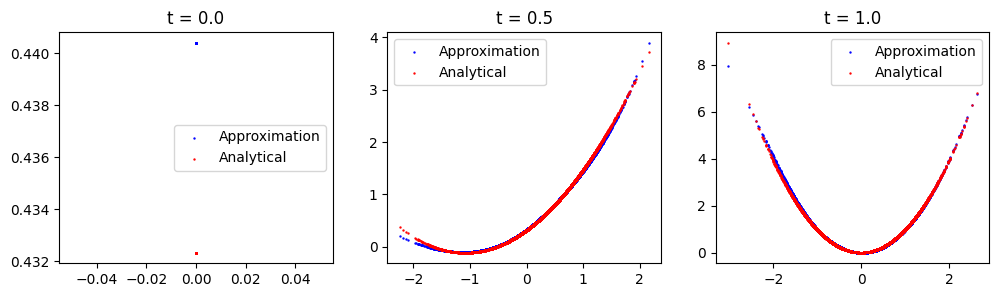

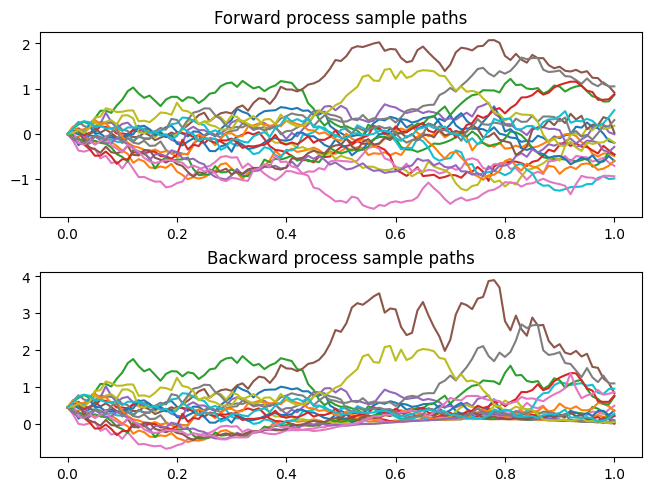

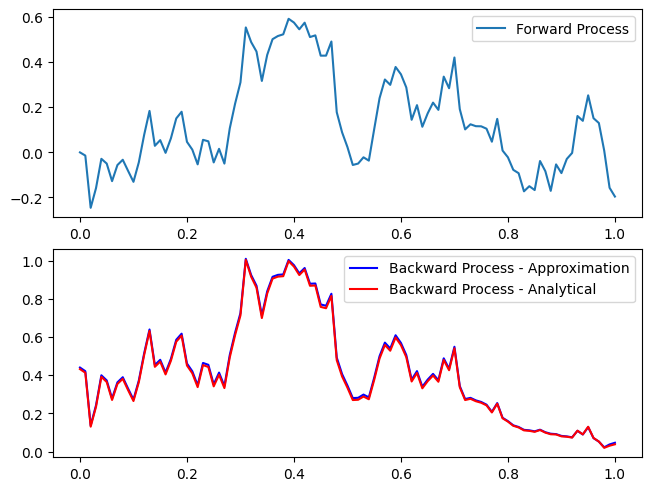

In [6]:
APPROXIMATOR_ARGS = {
        "batch_size": 20_000,
        "number_of_iterations": 2_000,
        "number_of_epochs": 20,
        "number_of_plots": 10,
        "plotter": artist,
    }

forward_backward_sde.backward_solve(approximator_args=APPROXIMATOR_ARGS)